In [ ]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
#from bertopic import BERTopic
#from bertopic.representation import KeyBERTInspired
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.patches import Rectangle
import pickle

<h2>Note on batches</h2>
Each batch is 7 days. Difference between each batch (stride) is 3 days. March is day 1 to 31. April is day 32 onwards.

<h2>1. Processing the batches

In [ ]:
docs_batch_1 = []
for i in range(1,8):
  with open(f'day{i}_pages1_3.txt', 'r') as text_file:
    for line in text_file:
      docs_batch_1.append(line)

docs_batch_2 = []
for i in range(4,11):
  with open(f'day{i}_pages1_3.txt', 'r') as text_file:
    for line in text_file:
      docs_batch_2.append(line)

docs_batch_3 = []
for i in range(7,14):
  with open(f'day{i}_pages1_3.txt', 'r') as text_file:
    for line in text_file:
      docs_batch_3.append(line)

docs_batch_4 = []
for i in range(10,17):
  with open(f'day{i}_pages1_3.txt', 'r') as text_file:
    for line in text_file:
      docs_batch_4.append(line)

docs_batch_5 = []
for i in range(13,20):
  with open(f'day{i}_pages1_3.txt', 'r') as text_file:
    for line in text_file:
      docs_batch_5.append(line)

docs_batch_6 = []
for i in range(16,23):
  with open(f'day{i}_pages1_3.txt', 'r') as text_file:
    for line in text_file:
      docs_batch_6.append(line)

docs_batch_7 = []
for i in range(19,26):
  with open(f'day{i}_pages1_3.txt', 'r') as text_file:
    for line in text_file:
      docs_batch_7.append(line)

docs_batch_8 = []
for i in range(22,29):
  with open(f'day{i}_pages1_3.txt', 'r') as text_file:
    for line in text_file:
      docs_batch_8.append(line)

docs_batch_9 = []
for i in range(25,32):
  with open(f'day{i}_pages1_3.txt', 'r') as text_file:
    for line in text_file:
      docs_batch_9.append(line)

docs_batch_10 = []
for i in range(28,35):
  with open(f'day{i}_pages1_3.txt', 'r') as text_file:
    for line in text_file:
      docs_batch_10.append(line)

docs_batch_11 = []
for i in range(31,38):
  with open(f'day{i}_pages1_3.txt', 'r') as text_file:
    for line in text_file:
      docs_batch_11.append(line)

docs_batch_12 = []
for i in range(34,41):
  with open(f'day{i}_pages1_3.txt', 'r') as text_file:
    for line in text_file:
      docs_batch_12.append(line)

docs_batch_13 = []
for i in range(37,44):
  with open(f'day{i}_pages1_3.txt', 'r') as text_file:
    for line in text_file:
      docs_batch_13.append(line)


(669, 630, 630, 630, 630, 630, 630, 630)

<h2>2. Prerequisites: batch obj definition, some basic functions

In [ ]:
#how i compare the embeddings of the topic representations instead of the whole topic embedding?
#if i compare the topic embedding, this makes tends to give larger topic clusters
#a similarity advantage, because the topic embedding would capture a lot of noise

import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
#create string representation of topic representation
def create_topic_embs(emb_model, topic_model):
  temp_df = topic_model.get_topic_info()
  reps = []
  num_topics = temp_df.shape[0]
  if -1 in temp_df['Topic'].tolist(): num_topics -= 1 #discount the noise topic
  for idx, row in temp_df.iterrows():
    rep_list = row['Representation']
    rep_str = " ".join(rep_list)
    reps.append(rep_str)

  embs = emb_model.encode(reps, show_progress_bar=True)
  return reps, embs

def compute_topic_sim(emb_model, emb_1, emb_2):
  #need to remove the noise category
  emb_1, emb_2 = emb_1[1:], emb_2[1:] #remove noise topic
  sim = cosine_similarity(emb_1, emb_2)
  return sim

def plot_topic_sim(sim_mat, label_1, label_2, threshold=0.9):
  masked_sim_mat = np.where(sim_mat >= threshold, sim_mat, np.nan)
  plt.figure(figsize=(10, 8))
  sns.heatmap(masked_sim_mat, cmap='coolwarm', annot=False, square=True,
            cbar_kws={'label': 'cosine_similarity'}, mask=np.isnan(masked_sim_mat),
              linecolor='gray', linewidths=0.05)
  plt.title(f"cosine similarity between {label_1} and {label_2}")
  plt.xlabel(f"{label_2} model topic idx")
  plt.ylabel(f"{label_1} model topic idx")
  plt.show()

def show_topic_labels(model):
  temp_df = model.get_topic_info()
  reps = []
  num_topics = temp_df.shape[0]
  if -1 in temp_df['Topic'].tolist(): num_topics -= 1 #discount the noise topic
  for idx, row in temp_df.iterrows():
    rep_list = row['Representation']
    rep_str = " ".join(rep_list)
    reps.append(rep_str)
  reps_df = pd.DataFrame(reps)
  return(reps_df)

In [ ]:
class Batch():

  def __init__(self, batch_docs, batch_name, emb_model, model=None, top_n_words=20,
               n_components=40, min_cluster_size=5, pos=False):
    self.docs = batch_docs
    self.name = batch_name
    self.emb_model = emb_model
    self.model = model
    self.top_n_words = top_n_words
    self.n_components = n_components
    self.min_cluster_size = min_cluster_size
    self.num_topics = None
    self.topic_embs = None
    self.topic_reps = None
    self.reduced_topic_embs = None
    self.pos = pos

  def create_bertopic(self, num_attempts=5):
    if self.model:
      return self

    for attempt in range(num_attempts):
      print(f"creating bertopic model for {self.name}, attempt {attempt + 1}/5...", end=" ")
      rep_model = KeyBERTInspired(top_n_words=self.top_n_words)

      dim_model = PCA(n_components=self.n_components)
      hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=self.min_cluster_size)

      topic_model = BERTopic(
        embedding_model=self.emb_model,
        umap_model=dim_model,
        hdbscan_model=hdbscan_model,
        representation_model=rep_model
      )

      topics, _ = topic_model.fit_transform(self.docs)
      num_topics = len(set(topic_model.get_topics().keys())) - (1 if -1 in topics else 0)

      if num_topics >= 4:
        print(f" done! found {num_topics} topics!")
        self.model = topic_model
        self.num_topics = num_topics
        break

      else:
        print(f"\n  Retry: only found {num_topics} topics. Retrying...", end=" '")

      print(f"Failed to generate sufficient topics after {num_attempts} retries.")
      self.model = topic_model  #save the last attempt anyway
      self.num_topics = num_topics

    return self

  def create_topic_embs_reps(self):
    if not self.model:
      print("model not initialized yet")
      return

    print("creating topic embeddings...", end="")
    self.topic_reps, self.topic_embs = create_topic_embs(self.emb_model, self.model)
    print(" done!")
    return self

  def get_topic_info(self, truncate=True):
    if not self.model:
      print("model not initialized yet")
      return

    df = self.model.get_topic_info()
    if truncate:
      df = df[['Topic', 'Count', 'Representation']]
    return df

  def reduce_topic_embs(self, n_comp=5, verbose=False):
    self.reduced_topic_embs = opt_pca(self.topic_embs[1:], verbose=verbose, n_comp=n_comp) #remove the noise topic
    return self


In [ ]:
 #sentence_embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

instructor_model = SentenceTransformer("hkunlp/instructor-base")

class InstructorEmbeddingWrapper:
    def __init__(self, model, instruction):
        self.model = model
        self.instruction = instruction

    def encode(self, documents, **kwargs):
        #convert to [instruction, text] format
        instructor_input = [[self.instruction, doc] for doc in documents]
        return self.model.encode(instructor_input, **kwargs)

instruction = "Create a semantic embedding that captures key themes and enables comparison across texts."
embedding_model = InstructorEmbeddingWrapper(instructor_model, instruction)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/66.2k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.43k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

<h2>3. EDA</h2>
checking the length of each doc representation; cosine similarity of doc representation and actual doc

In [ ]:
#EDA stuff
#3909 documents
#want to find avg number of non stop word tokens in each document --> 959 tokens per doc
from sklearn.feature_extraction.text import CountVectorizer

count_vec = CountVectorizer(stop_words='english')
all_docs = []

for i in range(1,44):
  with open(f'day{i}_pages1_3.txt', 'r') as text:

    for line in text:
      all_docs.append(line)

assert len(all_docs) == 3909
X = count_vec.fit_transform(all_docs)
X_array = X.toarray()


(scipy.sparse._csr.csr_matrix, (3909, 179696))

In [ ]:
token_counts = np.count_nonzero(X_array, axis=1)
len(token_counts)

3909

In [ ]:
np.mean(token_counts)
#959 unique tokens

np.float64(959.447429009977)

In [ ]:
test_doc = []
with open('day1_pages1_3.txt','r')as test:
  for line in test:
    test_doc.append(line)
    break

#test out cosine similarity between embedding of document and actual html article
test_doc_rep = embedding_model.encode(test_doc)
test_doc_rep.shape

1


(1, 768)

In [ ]:
actual_article = """
The world's most unhinged video wall (made out of Chromebooks) Saturday, March 1, 2025 This is the story of our three year long journey to turn a fleet of laptops into what can only be described as the world’s most unhinged video wall.
This project was a collaboration with my friend Aksel Salmi. I was responsible for the software, and he designed the incredible hardware, see his blog to learn about the unexpectedly complex hardware needed to mount these dismantled computers[1].
About three years ago, my Design teacher (The amazing Mr. Bush) came to us with an idea - our school was about to dispose of its fleet of Chromebooks, and he was wondering if we could build anything with them.
Meet the Lenovo ThinkPad 11e #
The Lenovo ThinkPad 11e could very well be the world’s worst laptop. It is also the standard-issue school laptop that reinforced eight-year-old me’s interest in computers.
We used this school-issued laptop through primary and the start of middle school. This is me in 5th grade using a school laptop while working on my PYP Exhibition project (a game on Scratch)[2].

Despite my emotional connection to them, today these devices are, for all intents and purposes, junk. And for that reason, my school began the process of replacing them (with marginally less junky laptops)
These things don’t receive software updates from Google anymore, they struggle loading most webpages and to top it off, they’re tied to some long forgotten Enterprise Enrolment system, so they can’t even be used without a school Google account.

What is a video wall? #
A video wall is a large display made up of multiple screens arranged together to create a single, seamless display across all the screens. In the case of our project, we decided to try reusing the laptop screens to build a video wall.

Can we drive the screens using separate hardware? #
Our first idea was to harvest just the laptop display panels and somehow drive them using a powerful computer that could power the 10 screens simultaneously. We did not go this route (due to the fact that we had no idea what we were doing, and a quick estimate of the time and costs involved scared us away).

Okay, before we try anything else, let’s just try synchronising a video across two devices #
Since the screens were attached to perfectly functional laptops, it was quickly apparent that we’d probably be better off letting each screen be driven independently by their own laptop motherboards.

At this point, there were still many questions (eg. how were we going to do that on Chromebooks), so we put aside that challenge to focus on the new issue this brings up: Can we synchronise a single video across multiple computers?

Our experiments brought us to the school’s computer lab, where we experimented with VLC’s streaming abilities to get a stream synchronised across devices on a single network, but this posed two challenges: This system is not designed for videos being perfectly in sync, nor was it designed for two clients to receive different video inputs (because the whole point of the video wall is to display one loooooong video across the screens, not 10 repeat copies of the same video).

We were stuck here until my ““breakthrough””.

For context, the story is currently in 2022. Two years earlier, I had been locked up in my room due to the COVID lockdown, and in this time, I had loads of fun building random realtime web apps, like a chat app and multiplayer drawing game. These apps worked thanks to socket.io, a (primarily) WebSocket based library that allows for low-latency, bi-directional communication.
Screenshot of a chat site I made to pass the time during the 2020 lockdown

I realised that my best bet to get videos synchronised would be by using a web page that used socket.io to sync the video playback across clients. Yes, there are better approaches, but simply doing something like this worked unreasonably well, all things considered.
I named this ExpressJS server/client system c-sync[3].

Thanks to c-sync (and tons of tinkering), after some time we had decently synchronised videos across computer screens through a webpage (or at least it seemed like it, testing on these desktop computers)
As it turns out, in reality, the Chromebooks are too slow for this to be a reliable approach to synchronising playback, and tiny discrepancies in loading times + latency + system clocks etc. lead to videos not being synchronised.

Now, I’m not entirely sure why this works so well, but I came up with a ridiculous solution by accident. When videos reach the end of playback, each client emits the start event.
This means that the slowest computers hold back the fastest computers, and get the chance to load the videos. This also means looping can be a very slightly jittery process (with each screen receiving 10 ‘start’ events), but as long as the first couple frames of the video are identical, nobody would even notice.

Sidenote: why not schedule with timestamps
Using this method, we have nearly perfectly synchronised video playback, and can play any video on any screen (meaning we can split a wide video into 10 segments, and each computer displays its respective part, all in sync with eachother)
A disassembled Chromebook open to a test video

We reached this stage within a month or two. Believe it or not, this project still had three years of work ahead of us. The biggest issue was Chromebook software. At this point, we had a website that we could manually open on each laptop to display a fullscreen synchronised video.

Ideally, we would want this to be entirely automated, so that as soon as a Chromebook receives power, it boots up automagically to the c-sync client page. Unfortunately, right now, booting the Chromebook would just take you to a Google login page (and one that was locked to our school domain to boot).

Also, just to add insult to injury, when batteries are removed, the laptops don’t turn themselves on when they receive power (you have to hold down the power button)

This meant that our next step would have to be to replace ChromeOS with something else.

The ‘ChromeOS Firmware Recovery Script’ is a magical piece of technology that somehow supports many different Chromebook motherboards. Ours was called ‘GLIMMER’. We just had to enter the built-in ‘Recovery Mode’, enable ‘Developer Mode’ and use the ChromeOS Shell to run the script.

Now we’re basically on the home stretch. All we needed to do was pick up some stable Linux distro, write a hacky startup script that loads up Chromium and simulates the keystrokes to fullscreen the video and we’re done!
We ran in to two main issues: Some Chromebooks (roughly half of our working laptops) would refuse to enter developer mode due to the enterprise enrolment, and while we were able to get the other half onto a Linux distro, video playback would consistently freeze after some time (actually they would lock up entirely).

It took us several months of on-and-off experimentation to figure out what to do. Essentially, the solution was to overwrite the entire default firmware with coreboot (which is also possible using MrChromebox’s script). We just needed to remove the ‘Write Protection’ screw from each laptop motherboard, and this seemed to bypass the enrolment too.
Yes, it’s imperfect #
Our video wall is imperfect. TN panel viewing angles suck, and the screens vary in colours and stuff. Yes, the synchronisation isn’t perfect, and yes, I’m sure there were better alternatives for nearly every decision we made along the way.

Yet I love our video wall, despite how absurdly weird it is. It’s a perfect representation of the iterative design process and a true testament to teamwork and collaboration. We turned E-Waste into something interesting. And maybe, just maybe, the real video wall was the friends we made along the way.
This project was made possible by the incredible work of so many people. Aside from my collaborator Aksel Salmi, our Design teacher Daniel Bush played a huge role in guiding us through the project.

Additionally, I wanted to thank the coreboot project and Matt ‘MrChromebox’ DeVillier for putting together the firmware and tools that allowed any of this to work. I would also like to thank Thomas Lange of the FAI project for his help in building the FAI.me based automated installer that saved us so many many many hours, as well as his support over email.

As silly as it sounds, this project was a backbone in my high-school experience. We hacked away at it every Monday for the past few years, and we grew up along the way too.
"""

In [ ]:
article_rep = embedding_model.encode([actual_article])
article_rep.shape

(1, 768)

In [ ]:
cos_sim = cosine_similarity(test_doc_rep, article_rep)
cos_sim

array([[0.9157233]], dtype=float32)

<h3>Create the batch objects (or load them in if saved previously)

In [ ]:
#!unzip mar_1_apr_12_batches.pkl.zip

with open('mar_1_apr_12_batches.pkl', 'rb') as saved:
  batches =  pickle.load(saved)

In [ ]:
#tranche 1: batches 1-8
batch_1 = Batch(docs_batch_1, 'mar_1_7', embedding_model)
batch_1.create_bertopic()
batch_1.create_topic_embs_reps()
batch_2 = Batch(docs_batch_2, 'mar_4_10', embedding_model)
batch_2.create_bertopic()
batch_2.create_topic_embs_reps()
batch_3 = Batch(docs_batch_3, 'mar_7_13', embedding_model)
batch_3.create_bertopic()
batch_3.create_topic_embs_reps()
batch_4 = Batch(docs_batch_4, 'mar_10_16', embedding_model)
batch_4.create_bertopic()
batch_4.create_topic_embs_reps()
batch_5 = Batch(docs_batch_5, 'mar_13_19', embedding_model)
batch_5.create_bertopic()
batch_5.create_topic_embs_reps()
batch_6 = Batch(docs_batch_6, 'mar_16_22', embedding_model)
batch_6.create_bertopic()
batch_6.create_topic_embs_reps()
batch_7 = Batch(docs_batch_7, 'mar_19_25', embedding_model)
batch_7.create_bertopic()
batch_7.create_topic_embs_reps()
batch_8 = Batch(docs_batch_8, 'mar_22_28', embedding_model)
batch_8.create_bertopic()
batch_8.create_topic_embs_reps()

creating bertopic model for mar_1_7, attempt 1/5... 

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

 done! found 6 topics!
creating topic embeddings...

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 done!
creating bertopic model for mar_4_10, attempt 1/5...  done! found 6 topics!
creating topic embeddings...

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 done!
creating bertopic model for mar_7_13, attempt 1/5... 
  Retry: only found 2 topics. Retrying... 'Failed to generate sufficient topics after 5 retries.
creating bertopic model for mar_7_13, attempt 2/5... 
  Retry: only found 2 topics. Retrying... 'Failed to generate sufficient topics after 5 retries.
creating bertopic model for mar_7_13, attempt 3/5...  done! found 7 topics!
creating topic embeddings...

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 done!
creating bertopic model for mar_10_16, attempt 1/5...  done! found 5 topics!
creating topic embeddings...

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 done!
creating bertopic model for mar_13_19, attempt 1/5...  done! found 6 topics!
creating topic embeddings...

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 done!
creating bertopic model for mar_16_22, attempt 1/5...  done! found 6 topics!
creating topic embeddings...

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 done!
creating bertopic model for mar_19_25, attempt 1/5...  done! found 6 topics!
creating topic embeddings...

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 done!
creating bertopic model for mar_22_28, attempt 1/5...  done! found 5 topics!
creating topic embeddings...

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 done!


In [ ]:
#tranche 2: batches 9-13
batch_9 = Batch(docs_batch_9, 'mar_25_31', embedding_model)
batch_9.create_bertopic()
batch_9.create_topic_embs_reps()
batch_10 = Batch(docs_batch_10, 'mar_28_apr_3', embedding_model)
batch_10.create_bertopic()
batch_10.create_topic_embs_reps()
batch_11 = Batch(docs_batch_11, 'mar_31_apr_6', embedding_model)
batch_11.create_bertopic()
batch_11.create_topic_embs_reps()
batch_12 = Batch(docs_batch_12, 'apr_3_9', embedding_model)
batch_12.create_bertopic()
batch_12.create_topic_embs_reps()
batch_13 = Batch(docs_batch_13, 'apr_6_12', embedding_model)
batch_13.create_bertopic()
batch_13.create_topic_embs_reps()

creating bertopic model for mar_25_31, attempt 1/5... 

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


  Retry: only found 3 topics. Retrying... 'Failed to generate sufficient topics after 5 retries.
creating bertopic model for mar_25_31, attempt 2/5... 
  Retry: only found 3 topics. Retrying... 'Failed to generate sufficient topics after 5 retries.
creating bertopic model for mar_25_31, attempt 3/5... 
  Retry: only found 3 topics. Retrying... 'Failed to generate sufficient topics after 5 retries.
creating bertopic model for mar_25_31, attempt 4/5... 
  Retry: only found 2 topics. Retrying... 'Failed to generate sufficient topics after 5 retries.
creating bertopic model for mar_25_31, attempt 5/5...  done! found 4 topics!
creating topic embeddings...

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 done!
creating bertopic model for mar_28_apr_3, attempt 1/5... 
  Retry: only found 3 topics. Retrying... 'Failed to generate sufficient topics after 5 retries.
creating bertopic model for mar_28_apr_3, attempt 2/5... 
  Retry: only found 3 topics. Retrying... 'Failed to generate sufficient topics after 5 retries.
creating bertopic model for mar_28_apr_3, attempt 3/5... 
  Retry: only found 2 topics. Retrying... 'Failed to generate sufficient topics after 5 retries.
creating bertopic model for mar_28_apr_3, attempt 4/5... 
  Retry: only found 2 topics. Retrying... 'Failed to generate sufficient topics after 5 retries.
creating bertopic model for mar_28_apr_3, attempt 5/5...  done! found 4 topics!
creating topic embeddings...

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 done!
creating bertopic model for mar_31_apr_6, attempt 1/5...  done! found 9 topics!
creating topic embeddings...

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 done!
creating bertopic model for apr_3_9, attempt 1/5...  done! found 9 topics!
creating topic embeddings...

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 done!
creating bertopic model for apr_6_12, attempt 1/5... 
  Retry: only found 3 topics. Retrying... 'Failed to generate sufficient topics after 5 retries.
creating bertopic model for apr_6_12, attempt 2/5... 
  Retry: only found 3 topics. Retrying... 'Failed to generate sufficient topics after 5 retries.
creating bertopic model for apr_6_12, attempt 3/5... 
  Retry: only found 2 topics. Retrying... 'Failed to generate sufficient topics after 5 retries.
creating bertopic model for apr_6_12, attempt 4/5...  done! found 6 topics!
creating topic embeddings...

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 done!


In [ ]:
tranche_2 = [batch_9, batch_10, batch_11, batch_12, batch_13]

In [ ]:
#create list of all batches
batches = tranche_1 + tranche_2

<h3>sanity check of the embeddings: get a cos sim mat of two topic embeddings and see if they make sense

In [ ]:
def compare_two_batches(batch_1, batch_2, emb_model,
                       verbose=False, threshold=0.5):

  #measure similarity
  print("calculating similarities...", end="")
  sim_mat = compute_topic_sim(emb_model, batch_1.topic_embs,
                              batch_2.topic_embs)
  print(" done!")
  sim_plot = plot_topic_sim(sim_mat, batch_1.name, batch_2.name, threshold=threshold)

  if verbose:
    batches = [batch_1, batch_2]
    #print topic and indices
    for batch in batches:
      print(batch.name)
      temp_2 = batch.model.get_topic_info()
      print(temp_2[['Topic', 'Count', 'Representation']])
      print('------------------------')

  return sim_mat


calculating similarities... done!


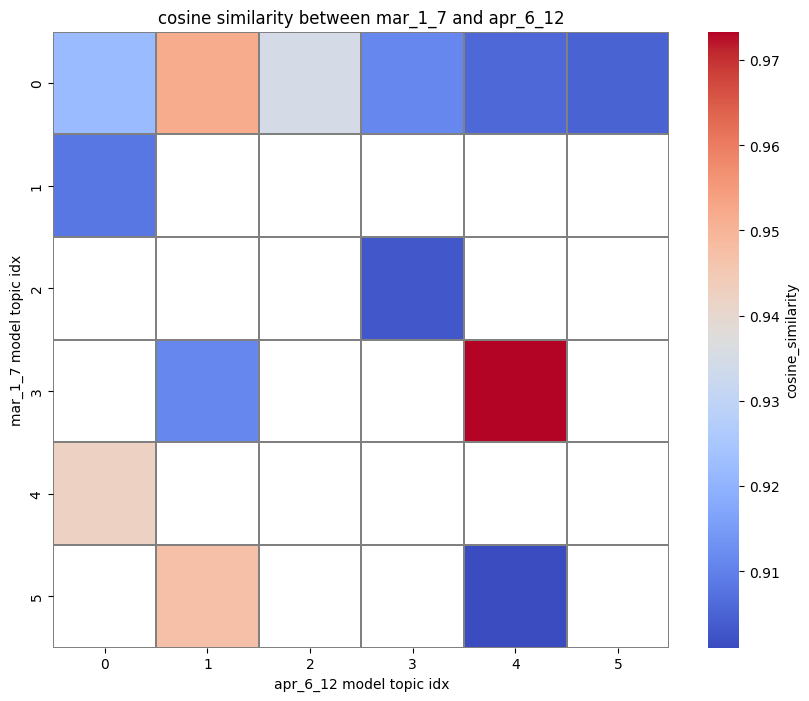

mar_1_7
   Topic  Count                                     Representation
0     -1    559  [us, really, most, https, think, we, much, wha...
1      0     60  [ai, language, memory, think, just, other, som...
2      1     12  [ukraine, putin, nato, russia, war, russian, n...
3      2     11  [vaccine, immune, measles, chewing, paternity,...
4      3     11  [mozilla, firefox, browsers, browser, chrome, ...
5      4      9  [congress, federal, government, spending, pres...
6      5      7  [ram, intel, vram, memory, hardware, cores, cp...
------------------------
apr_6_12
   Topic  Count                                     Representation
0     -1    552  [most, really, what, good, more, just, have, d...
1      0     27  [market, government, trump, money, what, being...
2      1     13  [syntax, performance, code, zig, language, mem...
3      2     12  [ai, thinking, reasoning, llms, models, think,...
4      3     12  [famine, aspirin, cancer, coffee, food, what, ...
5      4      8  [br

array([[0.92177606, 0.9516835 , 0.93480974, 0.9109911 , 0.9056973 ,
        0.904762  ],
       [0.90839225, 0.8745279 , 0.8789101 , 0.890458  , 0.87010044,
        0.87767166],
       [0.8785277 , 0.865333  , 0.86921597, 0.90292925, 0.87261206,
        0.85401547],
       [0.89464545, 0.9111729 , 0.8883816 , 0.88779515, 0.97334087,
        0.8834226 ],
       [0.9420196 , 0.8750144 , 0.88225186, 0.88086027, 0.8806642 ,
        0.8543497 ],
       [0.88166296, 0.94722456, 0.8869548 , 0.8916631 , 0.9010552 ,
        0.8841394 ]], dtype=float32)

In [ ]:
#sanity check to see cosine similarity of embeddings in two batches
compare_two_batches(batches[0], batches[-1], embedding_model, verbose=True, threshold=0.90)

<h1>4. Timeseries analysis of topics</h1>
<h3>Tried three different methods to get meta-clusters. First, looking at the cos sim pairwise across all topics (but this was too uninterpretable). Second, using kmeans on the topic embeddings (this is the method that we describe in our report). Third, using kmeans on the cosine similarities for each topic and every other topic (this method also worked, but we decided against using this because it's more difficult to explain).

<h3>creating the all_embs matrix, basically a concatenation of all the topic embeddings

In [ ]:
#vstack all topic embeddings without the noise category
all_embs = None
for idx, batch in enumerate(batches):
  #if batch.name == 'mar_22_28': continue
  topic_emb = batch.topic_embs[1:] #remove noise category
  print(batch.name, topic_emb.shape[0])
  if idx==0:
    all_embs = topic_emb
  else:
    all_embs = np.vstack([all_embs, topic_emb])

all_embs.shape

mar_1_7 6
mar_4_10 6
mar_7_13 7
mar_10_16 5
mar_13_19 6
mar_16_22 6
mar_19_25 6
mar_22_28 5
mar_25_31 4
mar_28_apr_3 4
mar_31_apr_6 9
apr_3_9 9
apr_6_12 6


(79, 768)

In [ ]:
def opt_pca(embeddings, verbose=False, n_comp=None):
  pca = PCA()
  pca.fit(embeddings)
  eigen_vals = pca.explained_variance_
  cum_var = np.cumsum(eigen_vals)/np.sum(eigen_vals)
  x_index = np.argmax(cum_var >= 0.9)
  y_val = cum_var[x_index]
  opt_n_comp = x_index+1

  if verbose:
    plt.figure(figsize=(10,6))
    plt.plot(range(1,len(eigen_vals)+1), cum_var, marker='o')
    plt.axhline(y=0.9, color='r', linestyle='--')
    plt.xlabel('Number of principal components')
    plt.ylabel('Variance explained')
    plt.title('Variance explained as number of principal components increases')
    plt.scatter(y=y_val, x=x_index+1, color='red', zorder=3, label=f'({x_index + 1}, {y_val:.2f})') #need to do x_index+1 because the
    plt.legend()
    plt.show()

  if n_comp:
    opt_n_comp = n_comp

  print(f"Creating opt PCA with n_components={opt_n_comp}")
  opt_pca = PCA(n_components=opt_n_comp)
  reduced_embeddings = opt_pca.fit_transform(embeddings)
  return reduced_embeddings

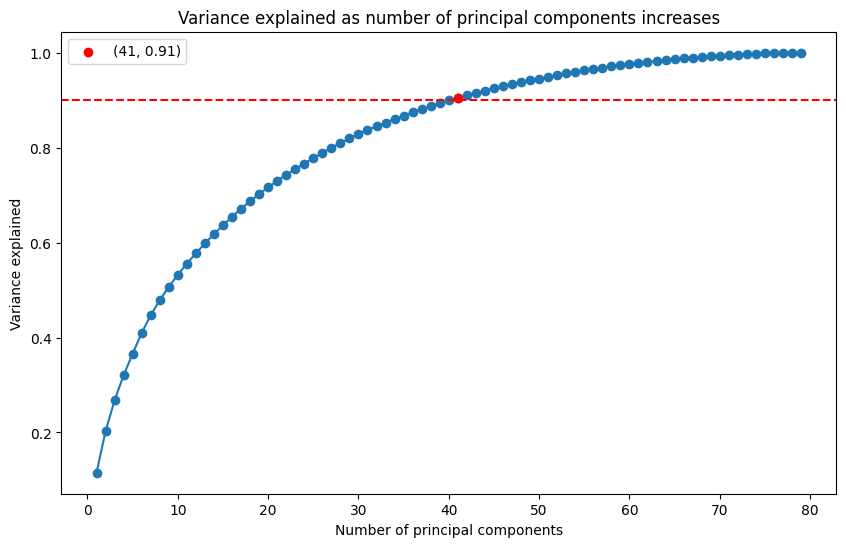

Creating opt PCA with n_components=10


In [ ]:
#dimensionality reduce all_embs
reduced_all_embs = opt_pca(all_embs, verbose=True, n_comp=10)

In [ ]:
reduced_all_embs.shape

(79, 10)

<h3>chose dimensionality of 10 beacuse it's above 0.5 and i want to keep the dimensionality low for the kmeans clustering

In [ ]:
#create df of topics
all_data = []
for batch in batches:
  topic_reps = batch.topic_reps
  temp = batch.get_topic_info()
  temp = temp['Count']
  for id, rep in enumerate(topic_reps):
    if id==0: continue #skip the noise topic
    data = {'batch': batch.name,
            'batch_id': id,
            'count': temp.iloc[id],
            'topic_rep': rep,
            }
    all_data.append(data)

all_data_df = pd.DataFrame(all_data)
all_data_df.shape

(79, 4)

79


Text(0.5, 1.0, 'first two dims of 79 topic embeddings')

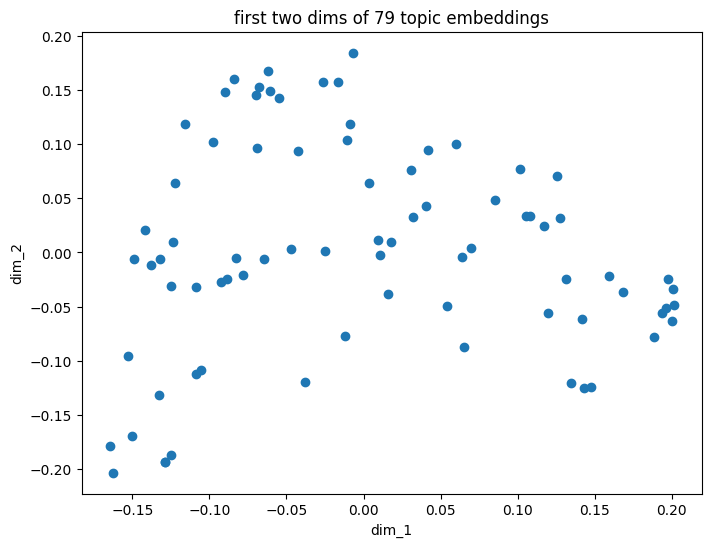

In [ ]:
#take a look at first two dims of reduced_all_embs
dim_1 = reduced_all_embs[:,0]
dim_2 = reduced_all_embs[:,1]
assert len(dim_1)==len(dim_2)
print(len(dim_1))
plt.figure(figsize=(8,6))
plt.scatter(dim_1, dim_2)
plt.xlabel('dim_1')
plt.ylabel('dim_2')
plt.title('first two dims of 79 topic embeddings')

<h1>Method 1: cos sim analysis

In [ ]:
#cosine similarity of all topics

def create_cos_sim_mat(all_embs, threshold=0.9):
  cos_sim_mat = cosine_similarity(all_embs)
  masked_mat = np.where(cos_sim_mat >= threshold, cos_sim_mat, np.nan)
  return cos_sim_mat, masked_mat

#blocks as start indices
def plot_cos_sim(cos_sim_mat, blocks, save=False, file_name=None):
  plt.figure(figsize=(10,8))
  ax = sns.heatmap(
    cos_sim_mat,
    annot=False,
    cmap="viridis",
    xticklabels=True,
    yticklabels=True,
    linecolor='gray',
    linewidths=0.05
  )

  #add boxes for batches
  for i in range(len(blocks)-1):
    start = blocks[i]
    size = blocks[i+1] - blocks[i]
    rect = Rectangle(
        (start, start),     # (x, y)
        size,               # width
        size,               # height
        linewidth=2,
        edgecolor='red',
        facecolor='none'
    )
    ax.add_patch(rect)

  #titles, labels etc
  plt.title("Cosine Similarity Heatmap")
  plt.xlabel("Topic Index")
  plt.ylabel("Topic Index")
  if save:
    plt.savefig(f"{file_name}.jpg", dpi=300)
  plt.show()

#get boundaries for each batch
def get_bounds(batches):
  bounds = [0]
  for batch in batches:
    #if batch.name=='mar_22_28': continue
    topic_emb_shape = batch.topic_embs[1:].shape[0]
    last_bound = bounds[-1]
    new_bound = last_bound + topic_emb_shape
    bounds.append(new_bound)
  return bounds

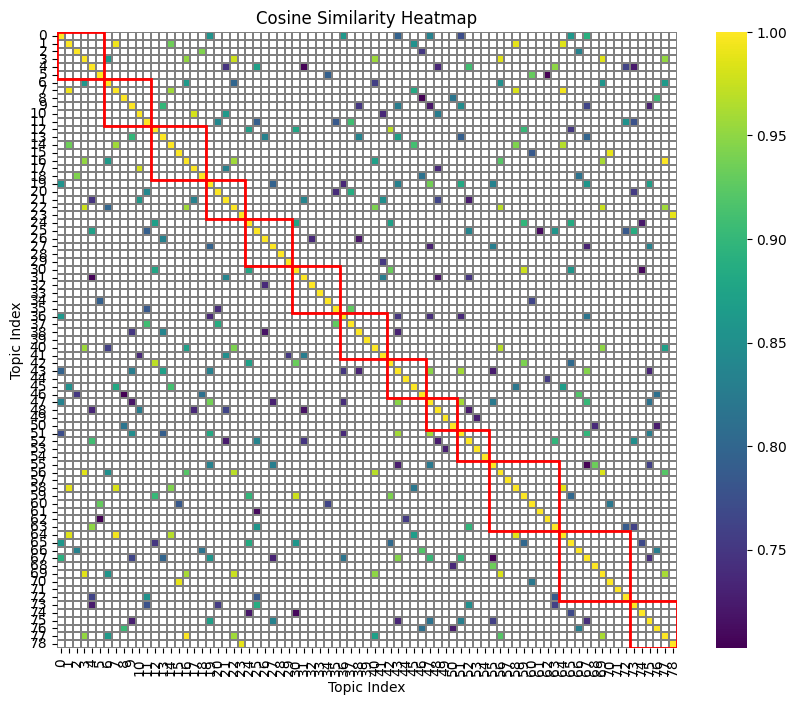

In [ ]:
#driver code
bounds = get_bounds(batches)
cos_sim_mat, masked = create_cos_sim_mat(reduced_all_embs, threshold=0.7)
plot_cos_sim(masked, bounds)

In [ ]:
def find_persistent_topics(batches, cos_sim_mat, bounds, masked=None, threshold=0.9):
  if not masked:
    masked = np.where(cos_sim_mat >= threshold, cos_sim_mat, np.nan)
  num_batches = len(batches)
  num_bounds = len(bounds)
  persistent_topics = []

  for topic_idx, row in enumerate(masked):
    is_persistent_topic = []
    for idx, bound in enumerate(bounds):
      if idx == num_bounds-1:
        break
      elif idx == num_bounds-2: #second last idx
        sub_row = row[bound:]
      else:
        sub_row = row[bound:bounds[idx+1]]

      non_na = np.where(~np.isnan(sub_row))[0] #returns a tuple
      if len(non_na)>0:
        is_persistent_topic.append(True)
      else: #empty list
        is_persistent_topic.append(False)

    is_persistent_topic = all(is_persistent_topic)
    if is_persistent_topic: persistent_topics.append(topic_idx)

  return persistent_topics, masked

In [ ]:
def get_persistent_topic_reps(batches, persistent_topics, masked, all_df):
  rows = masked[persistent_topics]
  for row in rows:
    non_nas = np.where(~np.isnan(row))[0]
    print(all_df.iloc[non_nas]['topic_rep'])

In [ ]:
persistent_topics, masked = find_persistent_topics(batches, cos_sim_mat, bounds, threshold=0.4)
get_persistent_topic_reps(batches, persistent_topics, masked, all_data_df)

0     ai language memory think just other some don r...
9     ai make llms company llm money really openai d...
12    compiler typescript runtime languages language...
13    engineers engineer ai work company make most s...
19    ai language are really llms think things llm w...
24    rust compiler java languages python language h...
27    ai learning neural code training what understa...
30    rust compiler compile macros zig memory langua...
36    ai build github rust ci don really just me we ...
42    macros rust xslt library zig xml environment c...
43    ai software me think code some just most don w...
47    ai language think just like me some be most re...
51    ai me work just people do some things don thin...
55    ai intelligence computable turing reasoning th...
59    rust compiler enums enum types compile const t...
65    pointer language code sqlite zig type other ha...
67    ai llms llm coding software make don are most ...
68    ai intelligence books book think read be l

<h1>method 2: kmeans clustering the embeddings directly

In [ ]:
#kmeans implementation
from sklearn.cluster import KMeans

In [ ]:
reduced_all_embs.shape

(79, 10)

In [ ]:
#hyperparameter tuning: test out how many clusters
num_clusters_to_test = np.arange(2,20)
within_cluster = [] #inertia attribute
between_cluster = []
data = reduced_all_embs

for i in num_clusters_to_test:
  print(f"testing {i} clusters")
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(data)
  within_cluster.append(kmeans.inertia_)

  #calculate between cluster
  overall_centroid = np.mean(data, axis=0)
  bcss = 0
  for i in range(kmeans.n_clusters):
    cluster_points = data[kmeans.labels_==i]
    cluster_centroid = kmeans.cluster_centers_[i]
    bcss += len(cluster_points) * np.sum((cluster_centroid - overall_centroid) ** 2) #square of clust_cent and overall_centr * num points in cluster
  between_cluster.append(bcss)

testing 2 clusters
testing 3 clusters
testing 4 clusters
testing 5 clusters
testing 6 clusters
testing 7 clusters
testing 8 clusters
testing 9 clusters
testing 10 clusters
testing 11 clusters
testing 12 clusters
testing 13 clusters
testing 14 clusters
testing 15 clusters
testing 16 clusters
testing 17 clusters
testing 18 clusters
testing 19 clusters


Text(0.5, 1.0, 'ratio of within_cluster to between_cluster from n_clusters 2 to 7')

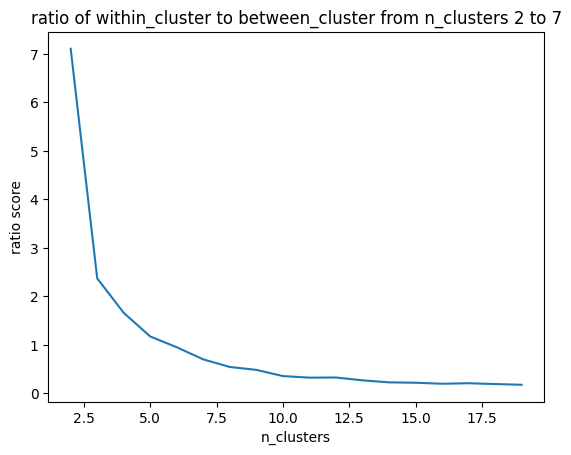

In [ ]:
#ratio of withinss and betweenss per cluster
ratio = [within/between for between, within in zip(between_cluster, within_cluster)]
plt.plot(num_clusters_to_test, ratio)
plt.xlabel('n_clusters')
plt.ylabel('ratio score')
plt.title('ratio of within_cluster to between_cluster from n_clusters 2 to 7')

In [ ]:
#optimal is n_clusters=10
kmeans = KMeans(n_clusters=10, random_state=42)
labels = kmeans.fit_predict(all_embs)
labels_df = pd.DataFrame(labels)
labels_df.value_counts()

,count
0,
1,20
6,12
4,10
2,8
8,7
3,7
9,6
5,4
0,3


In [ ]:
len(labels)

79

In [ ]:
all_data_df['topic_cluster_label'] = labels_df
all_data_df

,batch,batch_id,count,topic_rep,topic_cluster_label
0,mar_1_7,1,60,ai language memory think just other some don r...,1
1,mar_1_7,2,12,ukraine putin nato russia war russian nukes we...,3
2,mar_1_7,3,11,vaccine immune measles chewing paternity tatto...,9
3,mar_1_7,4,11,mozilla firefox browsers browser chrome chromi...,2
4,mar_1_7,5,9,congress federal government spending president...,6
...,...,...,...,...,...
74,apr_6_12,2,13,syntax performance code zig language memory cp...,8
75,apr_6_12,3,12,ai thinking reasoning llms models think traini...,1
76,apr_6_12,4,12,famine aspirin cancer coffee food what about t...,9
77,apr_6_12,5,8,browser mozilla browsers chrome ads safari fir...,2


In [ ]:
for label, group in all_data_df.groupby('topic_cluster_label'):
  print(f"cluster_label: {label}")
  print(group[['batch', 'count', 'topic_rep']])

cluster_label: 0
        batch  count                                          topic_rep
29  mar_13_19      5  twitter media bsky social bluesky political tr...
48  mar_25_31     12  politicians law trump government legal politic...
49  mar_25_31     11  phishing privacy security emails domain passwo...
cluster_label: 1
           batch  count                                          topic_rep
0        mar_1_7     60  ai language memory think just other some don r...
9       mar_4_10     14  ai make llms company llm money really openai d...
13      mar_7_13     22  engineers engineer ai work company make most s...
19     mar_10_16     55  ai language are really llms think things llm w...
26     mar_13_19     11  tech engineer engineering work engineers job w...
27     mar_13_19      9  ai learning neural code training what understa...
32     mar_16_22     11  softbank o1 company google get patent venv bet...
33     mar_16_22      9  species evolution permian galaxies world unive...
36 

In [ ]:
#color code the clusters

all_data_df['dim_1'] = dim_1
all_data_df['dim_2'] = dim_2
all_data_df.head()

,batch,batch_id,count,topic_rep,topic_cluster_label,dim_1,dim_2
0,mar_1_7,1,60,ai language memory think just other some don r...,1,-0.115555,0.118436
1,mar_1_7,2,12,ukraine putin nato russia war russian nukes we...,3,0.196403,-0.051225
2,mar_1_7,3,11,vaccine immune measles chewing paternity tatto...,9,0.053917,-0.049795
3,mar_1_7,4,11,mozilla firefox browsers browser chrome chromi...,2,-0.150391,-0.169889
4,mar_1_7,5,9,congress federal government spending president...,6,0.159233,-0.021974


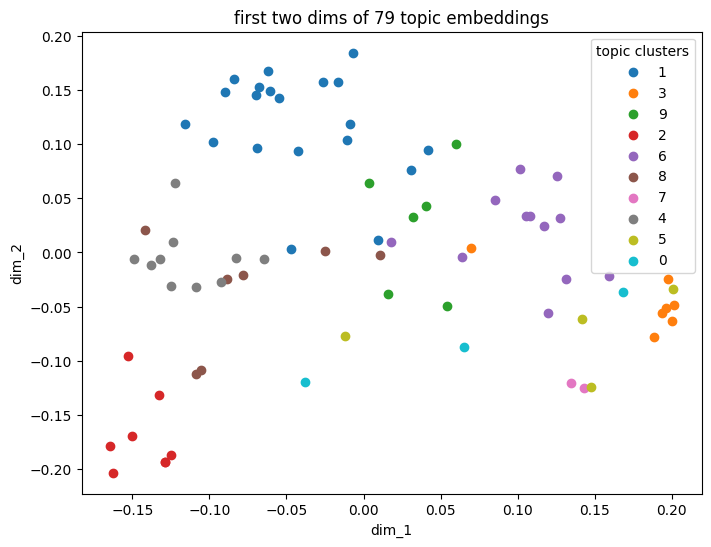

In [ ]:
import matplotlib.pyplot as plt

labels = all_data_df['topic_cluster_label'].unique()

plt.figure(figsize=(8, 6))
for label in labels:
    subset = all_data_df[all_data_df['topic_cluster_label'] == label]
    plt.scatter(subset['dim_1'], subset['dim_2'], label=label)

plt.legend(title='topic clusters')
plt.title('first two dims of 79 topic embeddings')
plt.xlabel('dim_1')
plt.ylabel('dim_2')
plt.show()


In [ ]:
all_data_df.to_csv('mar_apr_all_data_df_emb_kmeans_dims.csv')

<h1>method 3: cluster the sim mat itself

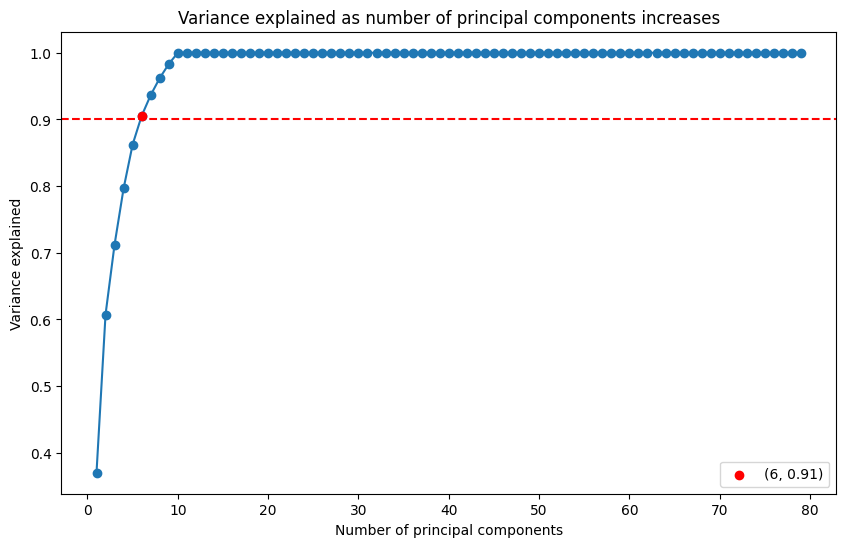

Creating opt PCA with n_components=6


(79, 6)

In [ ]:
#clustering of the sim mat
cos_sim_mat.shape
reduced_cos_sim_mat = opt_pca(cos_sim_mat, verbose=True)
reduced_cos_sim_mat.shape

In [ ]:
#hyperparameter tuning: test out how many clusters
num_clusters_to_test = np.arange(2,20)
within_cluster = [] #inertia attribute
between_cluster = []
data = reduced_cos_sim_mat

for i in num_clusters_to_test:
  print(f"testing {i} clusters")
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(data)
  within_cluster.append(kmeans.inertia_)

  #calculate between cluster
  overall_centroid = np.mean(data, axis=0)
  bcss = 0
  for i in range(kmeans.n_clusters):
    cluster_points = data[kmeans.labels_==i]
    cluster_centroid = kmeans.cluster_centers_[i]
    bcss += len(cluster_points) * np.sum((cluster_centroid - overall_centroid) ** 2) #square of clust_cent and overall_centr * num points in cluster
  between_cluster.append(bcss)

testing 2 clusters
testing 3 clusters
testing 4 clusters
testing 5 clusters
testing 6 clusters
testing 7 clusters
testing 8 clusters
testing 9 clusters
testing 10 clusters
testing 11 clusters
testing 12 clusters
testing 13 clusters
testing 14 clusters
testing 15 clusters
testing 16 clusters
testing 17 clusters
testing 18 clusters
testing 19 clusters


Text(0.5, 1.0, 'ratio of within_cluster to between_cluster from n_clusters 2 to 7')

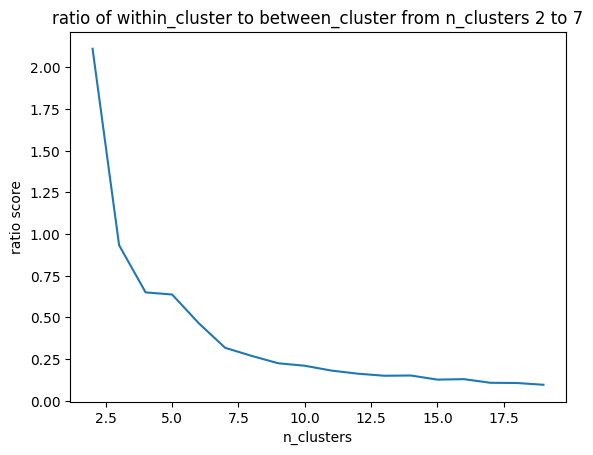

In [ ]:
#ratio of withinss and betweenss per cluster
ratio = [within/between for between, within in zip(between_cluster, within_cluster)]
plt.plot(num_clusters_to_test, ratio)
plt.xlabel('n_clusters')
plt.ylabel('ratio score')
plt.title('ratio of within_cluster to between_cluster from n_clusters 2 to 7')

In [ ]:
reduced_cos_sim_mat.shape

(79, 6)

In [ ]:
kmeans_cos_sim_mat = KMeans(n_clusters=8, random_state=42)
labels = kmeans_cos_sim_mat.fit_predict(reduced_cos_sim_mat)
labels_df = pd.Series(labels)
labels_df.value_counts()

,count
1,15
4,11
2,11
6,10
3,9
7,8
0,8
5,7


In [ ]:
all_data_df_2 = all_data_df.copy()
all_data_df_2['topic_cluster_label'] = labels_df

In [ ]:
all_data_df_2

,batch,batch_id,count,topic_rep,topic_cluster_label
0,mar_1_7,1,60,ai language memory think just other some don r...,1
1,mar_1_7,2,12,ukraine putin nato russia war russian nukes we...,7
2,mar_1_7,3,11,vaccine immune measles chewing paternity tatto...,6
3,mar_1_7,4,11,mozilla firefox browsers browser chrome chromi...,3
4,mar_1_7,5,9,congress federal government spending president...,4
...,...,...,...,...,...
74,apr_6_12,2,13,syntax performance code zig language memory cp...,5
75,apr_6_12,3,12,ai thinking reasoning llms models think traini...,1
76,apr_6_12,4,12,famine aspirin cancer coffee food what about t...,6
77,apr_6_12,5,8,browser mozilla browsers chrome ads safari fir...,3


In [ ]:
for label, group in all_data_df_2.groupby('topic_cluster_label'):
  print(f"cluster_label: {label}")
  print(group[['batch', 'count', 'topic_rep']])

cluster_label: 0
           batch  count                                          topic_rep
10      mar_4_10      9  deported hamas terrorist protests freedom amen...
17      mar_7_13     10  deported hamas protests immigration terrorist ...
21     mar_10_16     15  immigration citizenship citizen visa canadian ...
29     mar_13_19      5  twitter media bsky social bluesky political tr...
31     mar_16_22     17  immigration risk american us canada border cou...
41     mar_19_25      5  detained immigration border police citizens ri...
48     mar_25_31     12  politicians law trump government legal politic...
53  mar_28_apr_3      8  privacy surveillance public police cameras cop...
cluster_label: 1
           batch  count                                          topic_rep
0        mar_1_7     60  ai language memory think just other some don r...
9       mar_4_10     14  ai make llms company llm money really openai d...
13      mar_7_13     22  engineers engineer ai work company make m

In [ ]:
all_data_df.to_csv('mar_apr_all_data_df_emb_kmeans.csv', index=False)

In [ ]:
all_data_df_2.to_csv('mar_apr_all_data_df_cossim_kmeans.csv', index=False)

In [ ]:
with open('mar_1_apr_12_batches.pkl', 'wb') as out_file:
  pickle.dump(batches, out_file)

<h1>5. Evaluation against a dumb but reasonable model: top 20 tf-idf words per batch, use ChatGPT to find trends

In [ ]:
all_docs = []
for i in range (1,44):
  with open(f'day{i}_pages1_3.txt', 'r') as read_in:
    for line in read_in:
      all_docs.append(line)

len(all_docs)

3909

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

for batch in batches:
    print(f"{batch.name}")
    batch_doc = batch.docs

    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(batch_doc)

    tfidf_scores = X.max(axis=0).toarray().flatten()  # Get max TF-IDF score for each word across documents
    words = vectorizer.get_feature_names_out()

    print(len(words), len(tfidf_scores))  # should match

    word_tfidf = pd.DataFrame({'word': words, 'tfidf': tfidf_scores})
    word_tfidf = word_tfidf.sort_values(by='tfidf', ascending=False)
    print(word_tfidf.head(20))
    print("----------")


mar_1_7
78176 78176
            word     tfidf
43362      mains  1.000000
13928    buffalo  0.950959
17028    cocaine  0.883758
60525       ruby  0.857877
70176       tmux  0.849766
43230    maestro  0.835853
75754     weimar  0.822435
31878        git  0.821048
42562     lonely  0.818996
23840     dnssec  0.810519
24716     duckdb  0.795598
23234    discord  0.787239
38378       ipad  0.776739
68838  terraform  0.773365
29522      flash  0.772297
53918     polars  0.769768
48552    nomadic  0.769647
30686    fuchsia  0.764474
74566      vinyl  0.755766
42076       lisp  0.750168
----------
mar_4_10
72271 72271
              word     tfidf
40036        mains  1.000000
15659      cocaine  0.907057
8438        arabic  0.884743
65541         trap  0.868623
64798         tmux  0.857332
40884          mcp  0.843022
18528          css  0.815316
53511        redis  0.812248
39294       lonely  0.805400
21321      discord  0.795616
49693       polars  0.781265
35479         ipad  0.770100
6291

<h1>6. now, let's try kmeans on the topic embeddings with only a subset of the data to do a "cross validation"

In [ ]:
#subset of only the first 5 batches
#vstack all topic embeddings without the noise category
subset_all_embs = None
for idx, batch in enumerate(batches):
  if idx==5: break
  topic_emb = batch.topic_embs[1:] #remove noise category
  if idx==0:
    subset_all_embs = topic_emb
  else:
    subset_all_embs = np.vstack([subset_all_embs, topic_emb])

subset_all_embs.shape

(30, 768)

In [ ]:
#reduce to 10 comps
pca_10 = PCA(n_components=10)
reduced_subset = pca_10.fit_transform(subset_all_embs)
reduced_subset.shape

(30, 10)

In [ ]:
#hyperparameter tuning: test out how many clusters
num_clusters_to_test = np.arange(2,20)
within_cluster = [] #inertia attribute
between_cluster = []
data = reduced_subset

for i in num_clusters_to_test:
  print(f"testing {i} clusters")
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(data)
  within_cluster.append(kmeans.inertia_)

  #calculate between cluster
  overall_centroid = np.mean(data, axis=0)
  bcss = 0
  for i in range(kmeans.n_clusters):
    cluster_points = data[kmeans.labels_==i]
    cluster_centroid = kmeans.cluster_centers_[i]
    bcss += len(cluster_points) * np.sum((cluster_centroid - overall_centroid) ** 2) #square of clust_cent and overall_centr * num points in cluster
  between_cluster.append(bcss)

testing 2 clusters
testing 3 clusters
testing 4 clusters
testing 5 clusters
testing 6 clusters
testing 7 clusters
testing 8 clusters
testing 9 clusters
testing 10 clusters
testing 11 clusters
testing 12 clusters
testing 13 clusters
testing 14 clusters
testing 15 clusters
testing 16 clusters
testing 17 clusters
testing 18 clusters
testing 19 clusters


Text(0.5, 1.0, 'ratio of within_cluster to between_cluster from n_clusters 2 to 7')

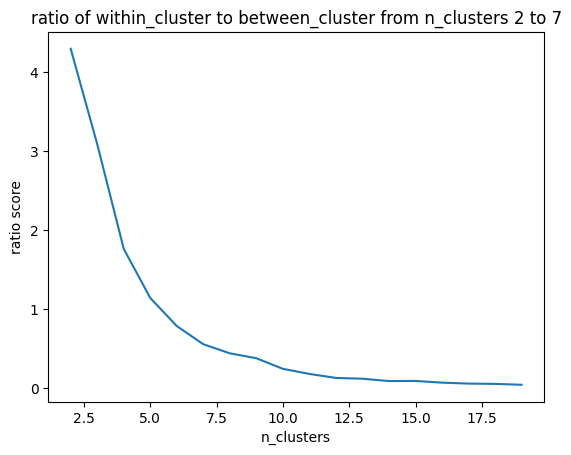

In [ ]:
#ratio of withinss and betweenss per cluster
ratio = [within/between for between, within in zip(between_cluster, within_cluster)]
plt.plot(num_clusters_to_test, ratio)
plt.xlabel('n_clusters')
plt.ylabel('ratio score')
plt.title('ratio of within_cluster to between_cluster from n_clusters 2 to 7')

In [ ]:
reduced_subset.shape

(30, 10)

In [ ]:
#choose 10 clusters for consistency
kmeans_10 = KMeans(n_clusters=10, random_state=42)
cv_labels = kmeans_10.fit_predict(reduced_subset)
cv_labels_df = pd.Series(cv_labels)
cv_labels_df.value_counts()

,count
3,7
1,4
4,3
0,3
2,3
6,3
8,3
5,2
9,1
7,1


In [ ]:
#create df of topics
subset_data = []
for batch in batches:
  topic_reps = batch.topic_reps
  temp = batch.get_topic_info()
  temp = temp['Count']
  for id, rep in enumerate(topic_reps):
    if id==0: continue #skip the noise topic
    data = {'batch': batch.name,
            'batch_id': id,
            'count': temp.iloc[id],
            'topic_rep': rep,
            }
    subset_data.append(data)

subset_data_df = pd.DataFrame(subset_data)
subset_data_df = subset_data_df.iloc[:30,:]
subset_data_df.shape

(30, 4)

In [ ]:
subset_data_df['topic_cluster_label'] = cv_labels_df
subset_data_df.sort_values('topic_cluster_label', inplace=True)
subset_data_df

,batch,batch_id,count,topic_rep,topic_cluster_label
4,mar_1_7,5,9,congress federal government spending president...,0
11,mar_4_10,6,6,economy economic tariffs market tesla stock pr...,0
25,mar_13_19,2,27,government money power amiga ponzi a500 social...,0
6,mar_4_10,1,58,chrome google memory browser mozilla because a...,1
16,mar_7_13,5,11,browser mozilla browsers chrome ads safari fir...,1
22,mar_10_16,4,9,ublock chrome mozilla browsers browser ads fir...,1
3,mar_1_7,4,11,mozilla firefox browsers browser chrome chromi...,1
10,mar_4_10,5,9,deported hamas terrorist protests freedom amen...,2
21,mar_10_16,3,15,immigration citizenship citizen visa canadian ...,2
17,mar_7_13,6,10,deported hamas protests immigration terrorist ...,2


In [ ]:
subset_group = subset_data_df.groupby('topic_cluster_label')

meta_topics_cv = []

for cluster_label, rows in subset_group:
  topic_reps = []
  topic_count, doc_count = 0,0
  for idx, row in rows.iterrows():
    topic_rep = row['topic_rep']
    topic_reps.append(topic_rep)
    topic_count += 1
    doc_count += row['count']
  " ".join(topic_reps)
   #calculate word freq
  vectorizer = CountVectorizer(stop_words='english')
  X = vectorizer.fit_transform(topic_reps)
  words = vectorizer.get_feature_names_out()
  words_np = np.array(words)
  freq = X.toarray()
  freq_sum = freq.sum(axis=0)
  freq_top_10_idx = np.argsort(freq_sum)[::-1][:20]
  meta_topic_rep = words_np[freq_top_10_idx]
  #print(f"meta-topic representation: {meta_topic_rep}")

  entry = {
    'cluster_label': cluster_label,
    'num_topics': topic_count,
    'num_docs': doc_count,
    'meta_topic_rep': meta_topic_rep
  }
  meta_topics_cv.append(entry)
  #print("-------")

meta_topics_cv_df = pd.DataFrame(meta_topics_cv)
meta_topics_cv_df
#meta_topics_cv_df.to_csv('meta_topics_cv_df.csv', index=False)

NameError: name 'subset_data_df' is not defined